In [1]:
import ast
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cross_validation import cross_val_score

In [2]:
# Vamos ler os dados ja dizendo para o pandas converter os campos que sabemos ser string para dict
df_train = pd.read_csv('train.csv', converters={'keydown': ast.literal_eval, 'keyup': ast.literal_eval})
df_test  = pd.read_csv('test.csv',  converters={'keydown': ast.literal_eval, 'keyup': ast.literal_eval})

df_train.head()

,id,target,keydown,keyup
0,1,1,"[{'code': 107, 'tick': 0}, {'code': 100, 'tick...","[{'code': 107, 'tick': 21}, {'code': 100, 'tic..."
1,2,1,"[{'code': 112, 'tick': 0}, {'code': 102, 'tick...","[{'code': 112, 'tick': 673}, {'code': 102, 'ti..."
2,3,1,"[{'code': 57, 'tick': 0}, {'code': 95, 'tick':...","[{'code': 57, 'tick': 588}, {'code': 95, 'tick..."
3,4,1,"[{'code': 50, 'tick': 0}, {'code': 67, 'tick':...","[{'code': 50, 'tick': 710}, {'code': 67, 'tick..."
4,5,1,"[{'code': 111, 'tick': 0}, {'code': 77, 'tick'...","[{'code': 111, 'tick': 500}, {'code': 77, 'tic..."


(-1.0045917329596941, 1.0, -1.0050287514769765, 1.0044247622374345)

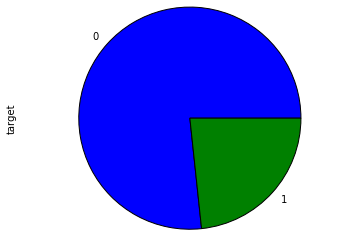

In [3]:
# Vamos ver a distribuicao da base
df_train.target.value_counts().plot(kind='pie')
plt.axis('equal')

## Feature engineering

In [4]:
# Pegando apenas os ticks
kd_ticks = df_train.keydown.apply(lambda keys: [key['tick'] for key in keys])
ku_ticks = df_train.keyup.apply(lambda keys: [key['tick'] for key in keys])
kd_ticks.head()

0    [0, 36, 76, 111, 153, 193, 232, 276, 319, 361,...
1    [0, 1536, 3058, 4578, 6107, 7628, 9141, 10663,...
2    [0, 1587, 3188, 4801, 6398, 7999, 9598, 11189,...
3    [0, 941, 1887, 2837, 3780, 4721, 5669, 6610, 7...
4    [0, 1337, 2674, 4005, 5345, 6679, 8025, 9362, ...
Name: keydown, dtype: object

In [5]:
# Pegando as diferencas entre os ticks
kd_ticks_diff = kd_ticks.apply(np.diff)
ku_ticks_diff = ku_ticks.apply(np.diff)
kd_ticks_diff.head()

0    [36, 40, 35, 42, 40, 39, 44, 43, 42, 43, 44, 4...
1    [1536, 1522, 1520, 1529, 1521, 1513, 1522, 151...
2    [1587, 1601, 1613, 1597, 1601, 1599, 1591, 159...
3    [941, 946, 950, 943, 941, 948, 941, 945, 942, ...
4    [1337, 1337, 1331, 1340, 1334, 1346, 1337, 132...
Name: keydown, dtype: object

In [9]:
# Gerando as features em cima dessas diferencas

# Gerando feature com a media dessas diferenças
df_train['down-to-down_mean'] = kd_ticks_diff.apply(np.mean)
df_train['up-to-up_mean'] = ku_ticks_diff.apply(np.mean)

# Gerando feature com o valo minimo dessas diferenças
df_train['down-to-down_min'] = kd_ticks_diff.apply(min)
df_train['up-to-up_min'] = ku_ticks_diff.apply(min)

# GERAR MAIS FEATURES AQUI
# Outras diferencas podem ser geradas para ser base de mais features
# Qualquer analise que vc faria para diferenciar uma pessoa de uma automacao pode ser expressada em uma feature

df_train.head()

,id,target,keydown,keyup,down-to-down_mean,up-to-up_mean,down-to-down_min,up-to-up_min
0,1,1,"[{'code': 107, 'tick': 0}, {'code': 100, 'tick...","[{'code': 107, 'tick': 21}, {'code': 100, 'tic...",40.333333,40.555556,29,28
1,2,1,"[{'code': 112, 'tick': 0}, {'code': 102, 'tick...","[{'code': 112, 'tick': 673}, {'code': 102, 'ti...",1520.631579,1520.105263,1513,1512
2,3,1,"[{'code': 57, 'tick': 0}, {'code': 95, 'tick':...","[{'code': 57, 'tick': 588}, {'code': 95, 'tick...",1600.842105,1601.631579,1587,1590
3,4,1,"[{'code': 50, 'tick': 0}, {'code': 67, 'tick':...","[{'code': 50, 'tick': 710}, {'code': 67, 'tick...",943.684211,943.842105,931,932
4,5,1,"[{'code': 111, 'tick': 0}, {'code': 77, 'tick'...","[{'code': 111, 'tick': 500}, {'code': 77, 'tic...",1336.947368,1336.368421,1323,1323


In [7]:
# O bug acima foi devido ao fato de ter digitacoes sem keyup, vamos ver quantos itens vazios existem.
ku_ticks_diff[ku_ticks_diff.str.len() == 0].count()

10

In [8]:
# Vamos filtrar os [] e substituir todos os com [] por [0]
ku_ticks_diff[ku_ticks_diff.str.len() == 0] =\
        ku_ticks_diff[ku_ticks_diff.str.len() == 0].apply(lambda empty: [0])

# Rode o passo anterior novamente e vera que nao existe mais itens vazios
# Rode o passo que gera as features novamente que agora nao tera mais bug

## Preparing data

In [10]:
# Removendo as features desnecessarias
df_train.drop(['id', 'keydown', 'keyup'], axis=1, inplace=True, errors='ignore')
df_train.head()

,target,down-to-down_mean,up-to-up_mean,down-to-down_min,up-to-up_min
0,1,40.333333,40.555556,29,28
1,1,1520.631579,1520.105263,1513,1512
2,1,1600.842105,1601.631579,1587,1590
3,1,943.684211,943.842105,931,932
4,1,1336.947368,1336.368421,1323,1323


In [13]:
# Vamos separar as features(X) das saidas(y)
features = df_train.columns.difference(['target'])

X = df_train[features].values
y = df_train['target'].values

features

Index(['down-to-down_mean', 'down-to-down_min', 'up-to-up_mean',
       'up-to-up_min'],
      dtype='object')

## PCA

In [40]:
# A documentacao do PCA diz que ele funciona melhor com datos reescalonados, entao vamos fazer isso.
# alguns classificadores tambem funcionam melhor com os dados assim (vide doc).
from sklearn.preprocessing import MaxAbsScaler
X_scaled = MaxAbsScaler().fit_transform(X)

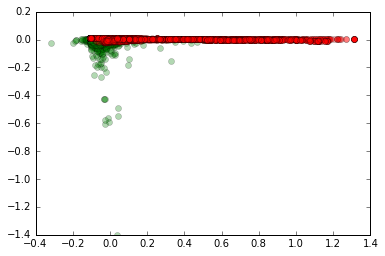

In [41]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
data = pca.fit_transform(X_scaled)

# Apos rodar o PCA vamos filtrar os dados baseado no target
data0 = data[df_train[df_train['target'] == 0].index.values]
data1 = data[df_train[df_train['target'] == 1].index.values]

# Vamos plotar os targets diferentes com cores diferentes
plt.plot(data0[:,0], data0[:,1], 'o', color='g', alpha=0.3)
plt.plot(data1[:,0], data1[:,1], 'o', color='r', alpha=0.3)

In [42]:
# Vamos ver o quanto da base original o PCA foi capaz de representar apos a reducao
pca.explained_variance_ratio_.sum()

0.99805727757707108

# Randon Forest Classifier

## Cross Validation

In [25]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=1986, n_estimators=10, bootstrap=True)
scores = cross_val_score(classifier, X, y, cv=3, scoring='log_loss')
scores, np.mean(scores)

(array([-0.38235402, -0.17797922, -1.4821624 ]), -0.68083187909976106)

## Grid Search

In [44]:
# Vamos achar os melhores parametros para o RF
from sklearn.grid_search import GridSearchCV

param_grid = {
            "criterion": ['entropy', 'gini'],
            "n_estimators": [10, 100],
            "bootstrap": [False, True],
            "max_depth": [8, 10, 15],
            #"max_features": ['auto', 0.08, 0.2, 0.3],
            #"min_samples_split": [2, 5, 10],
            #"min_samples_leaf": [1, 3, 5]
}

gs_classifier = GridSearchCV(classifier, param_grid, cv=3, scoring="log_loss")
gs_classifier.fit(X, y)

# Apos o fit o objeto gs_classifier tera as informacoes do busca de parametros
# Pode passar esses parametros para o 
classifier = gs_classifier.best_estimator_ 
gs_classifier.best_params_, gs_classifier.best_score_

({'bootstrap': False,
  'criterion': 'gini',
  'max_depth': 8,
  'n_estimators': 100},
 -0.18519793125733358)

## Train with all

In [26]:
# Apos validar o modelo com o cross validation, vamos treinar com tudo
# e assim podemos predizer a base de teste
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1986, verbose=0,
            warm_start=False)

## Predict test file

In [ ]:
# Antes de predizer a base de teste precisamos gerar nela 
# as mesmas features que geramos base de treino
y_pred = classifier.predict_proba(df_test[features])[:,1]
submission = pd.read_csv('sample_submission.csv')
submission['target'] = y_pred
submission.to_csv('result.csv', index=False)
# Aqui ja e possivel submitar sua solucao para o site da competicao

## Feature importances

In [46]:
# Vamos ver a importancia das features
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(importances)):
    print("   %5s: %f%%" % (features[indices[f]], importances[indices[f]]*100))

Feature ranking:
   up-to-up_min: 30.960244%
   down-to-down_mean: 26.945814%
   up-to-up_mean: 21.057295%
   down-to-down_min: 21.036647%


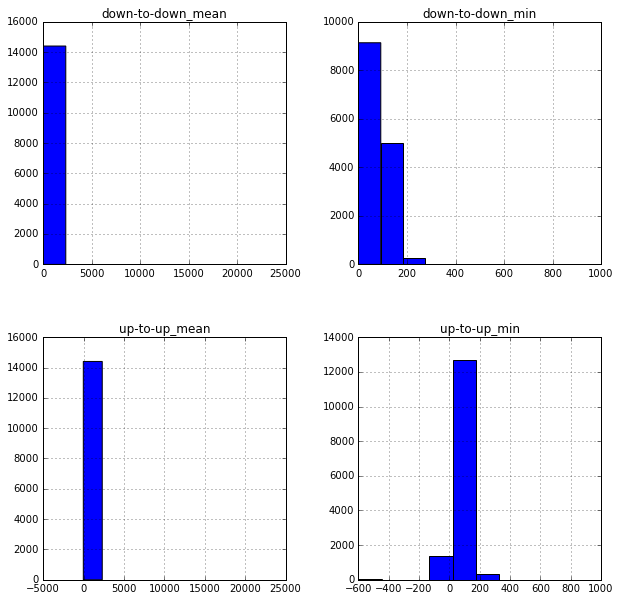

In [21]:
df_train[features][df_train.target == 0].hist(figsize=(10, 10));

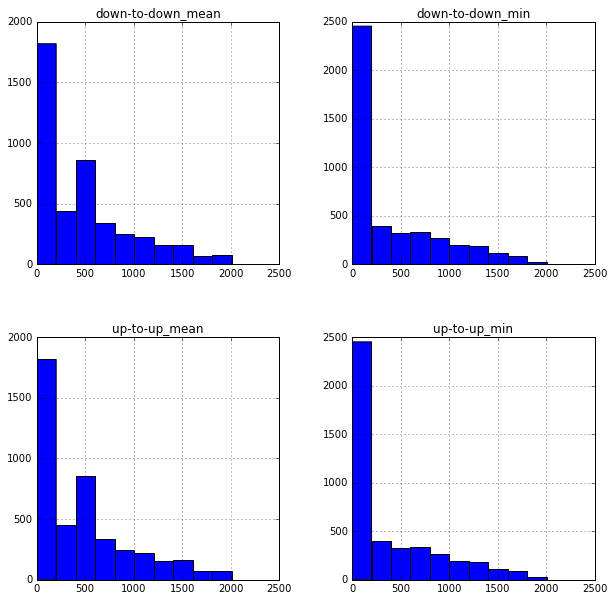

In [24]:
df_train[features][df_train.target == 1].hist(figsize=(10, 10));

## False positive/negative

In [49]:
# Vamos ver quantos e quais itens erramos na predicao com relacao ao valor verdadeiro
y_pred = classifier.predict(X)
df_error = df_train[y_pred != y]
len(df_error), df_error.index.values[0:5]

(495, array([47, 53, 56, 58, 64], dtype=int64))

In [ ]:
# Vamos plotar os dados originais do PCA
plt.plot(data0[:,0], data0[:,1], 'o', color='g', alpha=0.3)
plt.plot(data1[:,0], data1[:,1], 'o', color='r', alpha=0.3)

# Vamos plotar os falsos positivos/negativos em amarelo
data3 = data[df_error.index.values]
plt.plot(data3[:,0], data3[:,1], 'o', color='y', alpha=0.8)

# Podemos ver que o erro esta justamente no ponto onde os dados estao misturados
# com melhores features os dados irao se separar mais e diminuir o numero de erros

# EXTRA

## Plotting

In [27]:
# O Random Forest e um array de decision trees, desse forma podemos ver o tamanho e iterar pelo classificador
len(classifier)

10

In [28]:
#  Vammos pegar o primeiro decision tree do random forest
first_decision_tree = classifier[0]
first_decision_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=295817248, splitter='best')

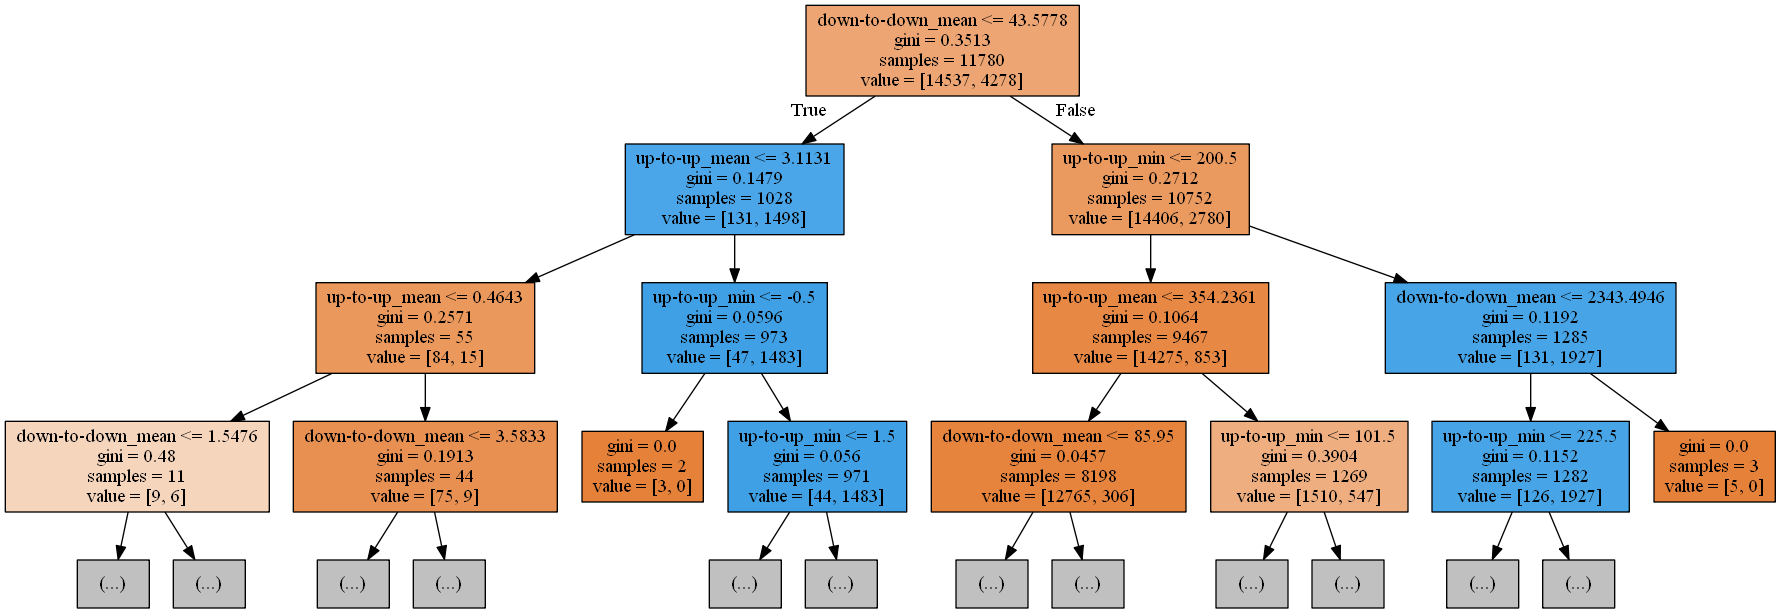

In [29]:
# Vamos desenhar esse decision tree apenas para entender melhor como funciona
from sklearn.tree import export_graphviz
import io
import pydot
import graphviz
from IPython.display import Image

dot_file = io.StringIO()
# Limitamos em profundida 3 para nao ficar mto grande, pode tirar esse parametro caso queira ver a arvore completa
export_graphviz(first_decision_tree, out_file=dot_file, max_depth=3, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_file.getvalue())

Image(graph[0].create_png())

# OUTROS CLASSIFICADORES

Exemplo de como um classificador (rede neural) faz o treinamento para pegar diferentes tipos de dados.
http://playground.tensorflow.org/

Exemplo de como diversos classificadores fazem para pegar os dados.
http://scikit-learn.org/stable/_images/plot_classifier_comparison_001.png

# Decision Tree Classifier

In [200]:
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier

classifier1 = DecisionTreeClassifier(random_state=1986, max_depth=10)
scores1 = cross_val_score(classifier1, X, y, cv=3, scoring='log_loss')
scores1, np.mean(scores1)

(array([-0.74761381, -0.46053383, -2.79084363]), -1.3329970886336728)

# Extra Trees Classifier

In [79]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
from sklearn.ensemble import ExtraTreesClassifier

classifier2 = ExtraTreesClassifier(random_state=1986, max_depth=10, n_estimators=10)
scores2 = cross_val_score(classifier2, X, y, cv=3, scoring='log_loss')
scores2, np.mean(scores2)

(array([-0.20617625, -0.22306319, -0.26356661]), -0.23093534866612031)

# Logistic Regression

In [237]:
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression

classifier3 = LogisticRegression(random_state=1986)
# Vamos usar a features reescalonadas aqui, pq esse algoritmo funciona melhor com ela
scores3 = cross_val_score(classifier3, X_scaled, y, cv=3, scoring='log_loss')
scores3, np.mean(scores3)

(array([-0.34389206, -0.72504722, -0.35454441]), -0.4744945653266564)

# K Neighbor Classifier

In [83]:
# https://goo.gl/yCWDS8
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn.neighbors import KNeighborsClassifier

classifier4 = KNeighborsClassifier(n_neighbors=150)  # 15, 30, 50, 100
scores4 = cross_val_score(classifier4, X, y, cv=3, scoring='log_loss')
scores4, np.mean(scores4)

(array([-0.25271627, -0.09436629, -0.35490673]), -0.23399643058042349)

# Gradient Boosting Classifier

In [84]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier

classifier5 = GradientBoostingClassifier(random_state=1986)
scores5 = cross_val_score(classifier5, X, y, cv=3, scoring='log_loss')
scores5, np.mean(scores5)

(array([-0.11379558, -0.08805422, -0.31942953]), -0.17375977601052353)

# eXtreme Gradient Boost

In [31]:
# Esse algoritmo nao existe no SkLearn, precisa ser baixado e compilado em sua maquina
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html
import xgboost as xgb

classifier6 = xgb.XGBClassifier(seed=1986,
                                n_estimators=100,
                                max_depth=6)
scores6 = cross_val_score(classifier6, X, y, cv=3, scoring='log_loss')
scores6, np.mean(scores6)

(array([-0.09839126, -0.06206244, -0.30104251]), -0.15383207095532261)

In [32]:
classifier6.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1986, silent=True, subsample=1)

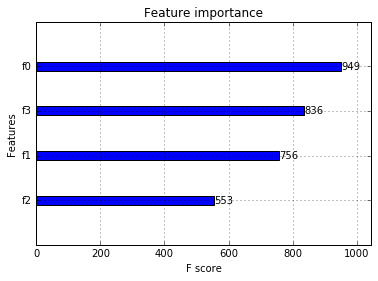

In [33]:
xgb.plot_importance(classifier6)

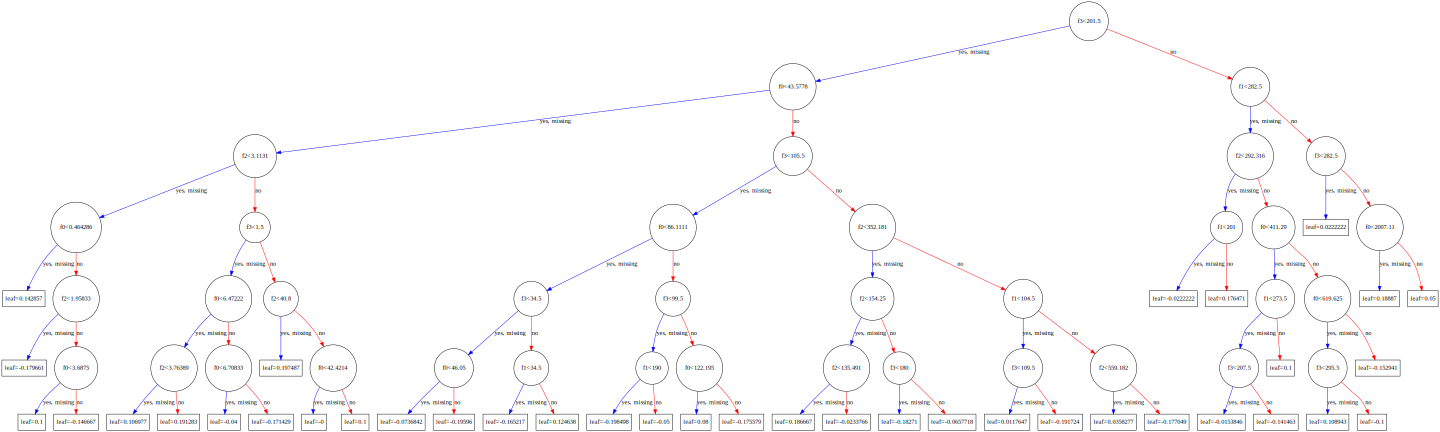

In [34]:
xgb.to_graphviz(classifier6, size='20!')

# Keras - Neural Network

In [41]:
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
np.random.seed(1986)

Using Theano backend.


C:\Users\CARLO_~1\AppData\Local\Temp\cc5IiMrg.o: In function `_import_array':
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1641: undefined reference to `__imp_PyExc_ImportError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1647: undefined reference to `__imp_PyExc_AttributeError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1652: undefined reference to `__imp_PyCapsule_Type'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1653: undefined reference to `__imp_PyExc_RuntimeError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1668: undefined reference to `__imp_PyExc_RuntimeError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1676: undefined reference to `__imp_PyExc_RuntimeError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1682: undefined reference to `__imp_PyExc_RuntimeError'
C:/Anaco

00001	#include <Python.h>
00002	#include "theano_mod_helper.h"
00003	#include "structmember.h"
00004	#include <sys/time.h>
00005	
00006	#if PY_VERSION_HEX >= 0x03000000
00007	#include "numpy/npy_3kcompat.h"
00008	#define PyCObject_AsVoidPtr  NpyCapsule_AsVoidPtr
00009	#define PyCObject_GetDesc  NpyCapsule_GetDesc
00010	#define PyCObject_Check NpyCapsule_Check
00011	#endif
00012	
00013	#ifndef Py_TYPE
00014	#define Py_TYPE(obj) obj->ob_type
00015	#endif
00016	
00017	/**
00018	
00019	TODO: 
00020	- Check max supported depth of recursion
00021	- CLazyLinker should add context information to errors caught during evaluation. Say what node we were on, add the traceback attached to the node.
00022	- Clear containers of fully-useed intermediate results if allow_gc is 1
00023	- Add timers for profiling
00024	- Add support for profiling space used.
00025	
00026	
00027	  */
00028	static double pytime(const struct timeval * tv)
00029	{
00030	  struct timeval t;
00031	  if (!tv)
00032	    {
00033	 

AttributeError: module 'theano' has no attribute 'gof'

In [38]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, init='uniform', activation='relu'))
model.add(Dense(8, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

NameError: name 'Sequential' is not defined

In [42]:
import theano
theano.test()

C:\Users\CARLO_~1\AppData\Local\Temp\ccXRu9Jc.o: In function `_import_array':
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1641: undefined reference to `__imp_PyExc_ImportError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1647: undefined reference to `__imp_PyExc_AttributeError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1652: undefined reference to `__imp_PyCapsule_Type'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1653: undefined reference to `__imp_PyExc_RuntimeError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1668: undefined reference to `__imp_PyExc_RuntimeError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1676: undefined reference to `__imp_PyExc_RuntimeError'
C:/Anaconda3/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1682: undefined reference to `__imp_PyExc_RuntimeError'
C:/Anaco

00001	#include <Python.h>
00002	#include "theano_mod_helper.h"
00003	#include "structmember.h"
00004	#include <sys/time.h>
00005	
00006	#if PY_VERSION_HEX >= 0x03000000
00007	#include "numpy/npy_3kcompat.h"
00008	#define PyCObject_AsVoidPtr  NpyCapsule_AsVoidPtr
00009	#define PyCObject_GetDesc  NpyCapsule_GetDesc
00010	#define PyCObject_Check NpyCapsule_Check
00011	#endif
00012	
00013	#ifndef Py_TYPE
00014	#define Py_TYPE(obj) obj->ob_type
00015	#endif
00016	
00017	/**
00018	
00019	TODO: 
00020	- Check max supported depth of recursion
00021	- CLazyLinker should add context information to errors caught during evaluation. Say what node we were on, add the traceback attached to the node.
00022	- Clear containers of fully-useed intermediate results if allow_gc is 1
00023	- Add timers for profiling
00024	- Add support for profiling space used.
00025	
00026	
00027	  */
00028	static double pytime(const struct timeval * tv)
00029	{
00030	  struct timeval t;
00031	  if (!tv)
00032	    {
00033	 

AttributeError: module 'theano' has no attribute 'gof'